In [70]:
import numpy as np
import pandas as pd
import imageio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
import skimage
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from tqdm import tqdm
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Reshape, Conv2D, MaxPool2D, concatenate, Activation, Dropout
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential, load_model
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

## Table of Contents

- [Introduction](#Introduction)
- [EDA](#EDA)
- [Image Processing](#Image-Preprocessing)
- [Architecture](#Architecture)
- [Training Model](#Training-Model)
    - [size: 28x28x3](#size:-28x28x3)
    - [size: 450x600x3](#size:-450x600x3)
    - [Further Optimization](#[Further-Optimization)
- [Conclusion](#Conclusion)


<a id='EDA'></a>
<a id='Image-Preocessing'></a>

## Introduction

The HAM10000 ("Human Against Machine with 10000 training images") dataset which contains 10,015 dermatoscopic images was made publically available by the Harvard database on June 2018 in the hopes to provide training data for automating the process of skin cancer lesion classifications. The motivation behind this act was to provide the public with an abundance and variability of data source for machine learning training purposes such that the results may be compared with that of human experts. If successful, the appplications would bring cost and time saving regimes to hospitals and medical professions alike. 

Apart from the 10,015 images, a metadata file with demographic information of each lesion is provided as well. More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal)

Data source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

The 7 classes of skin cancer lesions included in this dataset are:
1. Melanocytic nevi 
2. Melanoma 
3. Benign keratosis-like lesions 
4. Basal cell carcinoma 
5. Actinic keratoses 
6. Vascular lesions 
7. Dermatofibroma

## EDA

In [6]:
# importing metadata and double checking for its shape

metadata = pd.read_csv('C:/Users/user/Desktop/skincancer/HAM10000_metadata.csv')
print(metadata.shape)

(10015, 7)


In [7]:
# label encoding the seven classes for skin cancers

le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print(list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
7582,HAM_0003735,ISIC_0032512,nv,histo,40.0,female,back,5
2685,HAM_0001711,ISIC_0028677,bcc,histo,70.0,male,upper extremity,1
2580,HAM_0001616,ISIC_0029669,bcc,histo,65.0,female,back,1
3172,HAM_0001049,ISIC_0027703,nv,follow_up,50.0,female,trunk,5
2995,HAM_0002971,ISIC_0026425,nv,follow_up,45.0,female,lower extremity,5
6209,HAM_0003878,ISIC_0031072,nv,follow_up,30.0,female,foot,5
7947,HAM_0006559,ISIC_0033455,nv,histo,25.0,female,ear,5
5263,HAM_0003486,ISIC_0029494,nv,follow_up,50.0,female,abdomen,5
2413,HAM_0003873,ISIC_0024475,vasc,consensus,35.0,male,face,6
3273,HAM_0000154,ISIC_0025930,nv,follow_up,35.0,female,trunk,5


/home/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


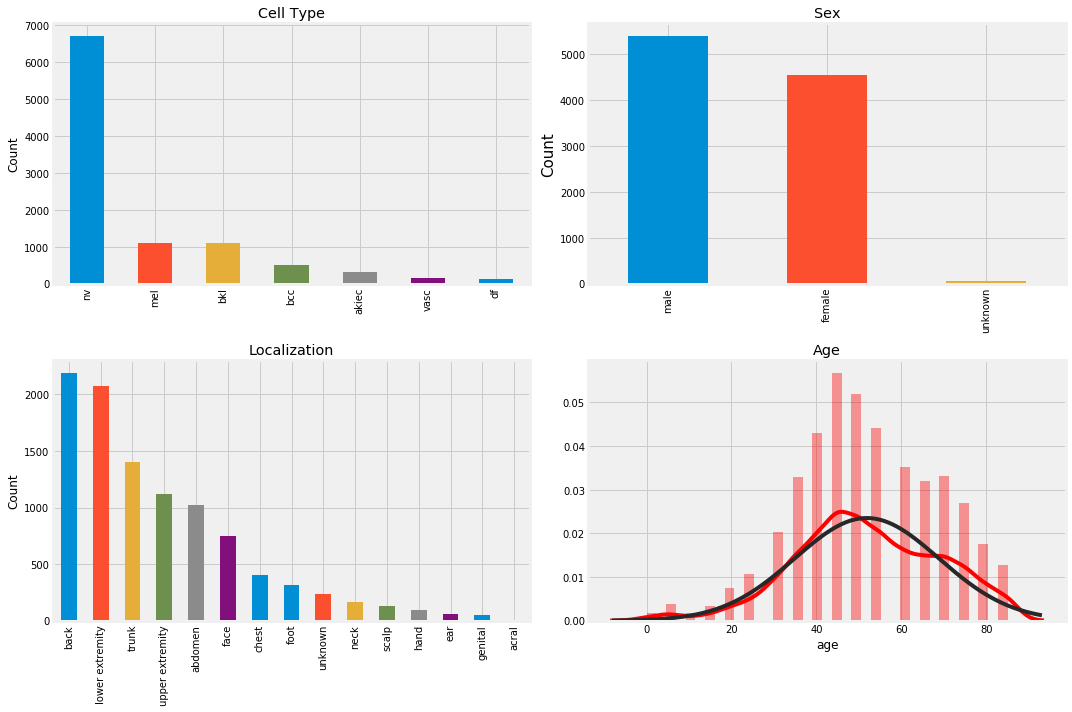

In [4]:
# Getting a sense of what the distribution of each column looks like

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

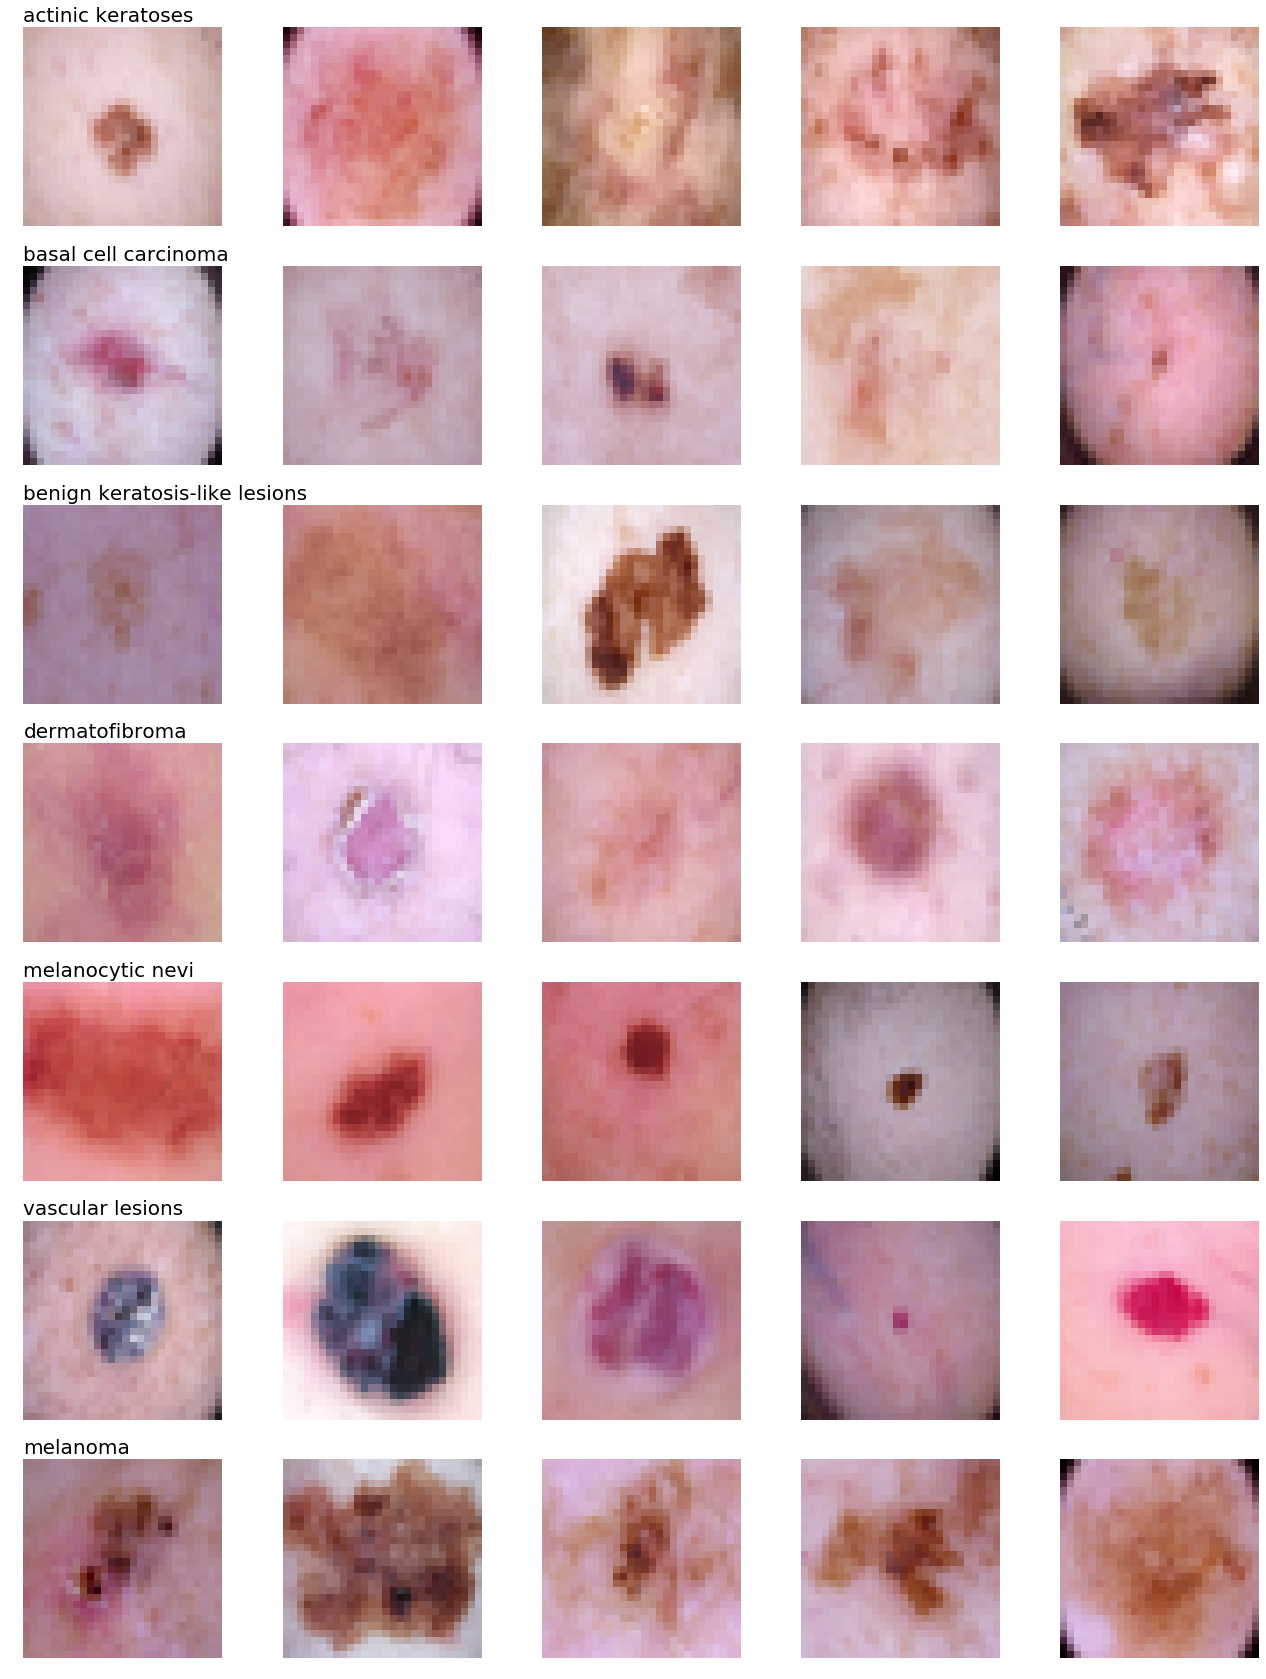

In [10]:
# drawing five samples from each class to see what the images look like in the 28x28 size

fig = plt.figure(figsize=(20, 30))
j=0
names = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions','dermatofibroma',
         'melanocytic nevi','vascular lesions','melanoma']

for class_number in range(7):
    
    example = x_train_s[np.where(y_train_s == class_number)][:5]

    for i, picture in enumerate(example):
        n=i+j
        picture.reshape(28,28,3)
        
        plt.subplot(7,5,n+1)
        plt.imshow(picture)
        if i ==0:
            plt.title(f'{names[class_number]}', size=20, loc='left')

        plt.axis('off')
    j+=5
plt.show()
fig.savefig('small_pix_sample.jpg')

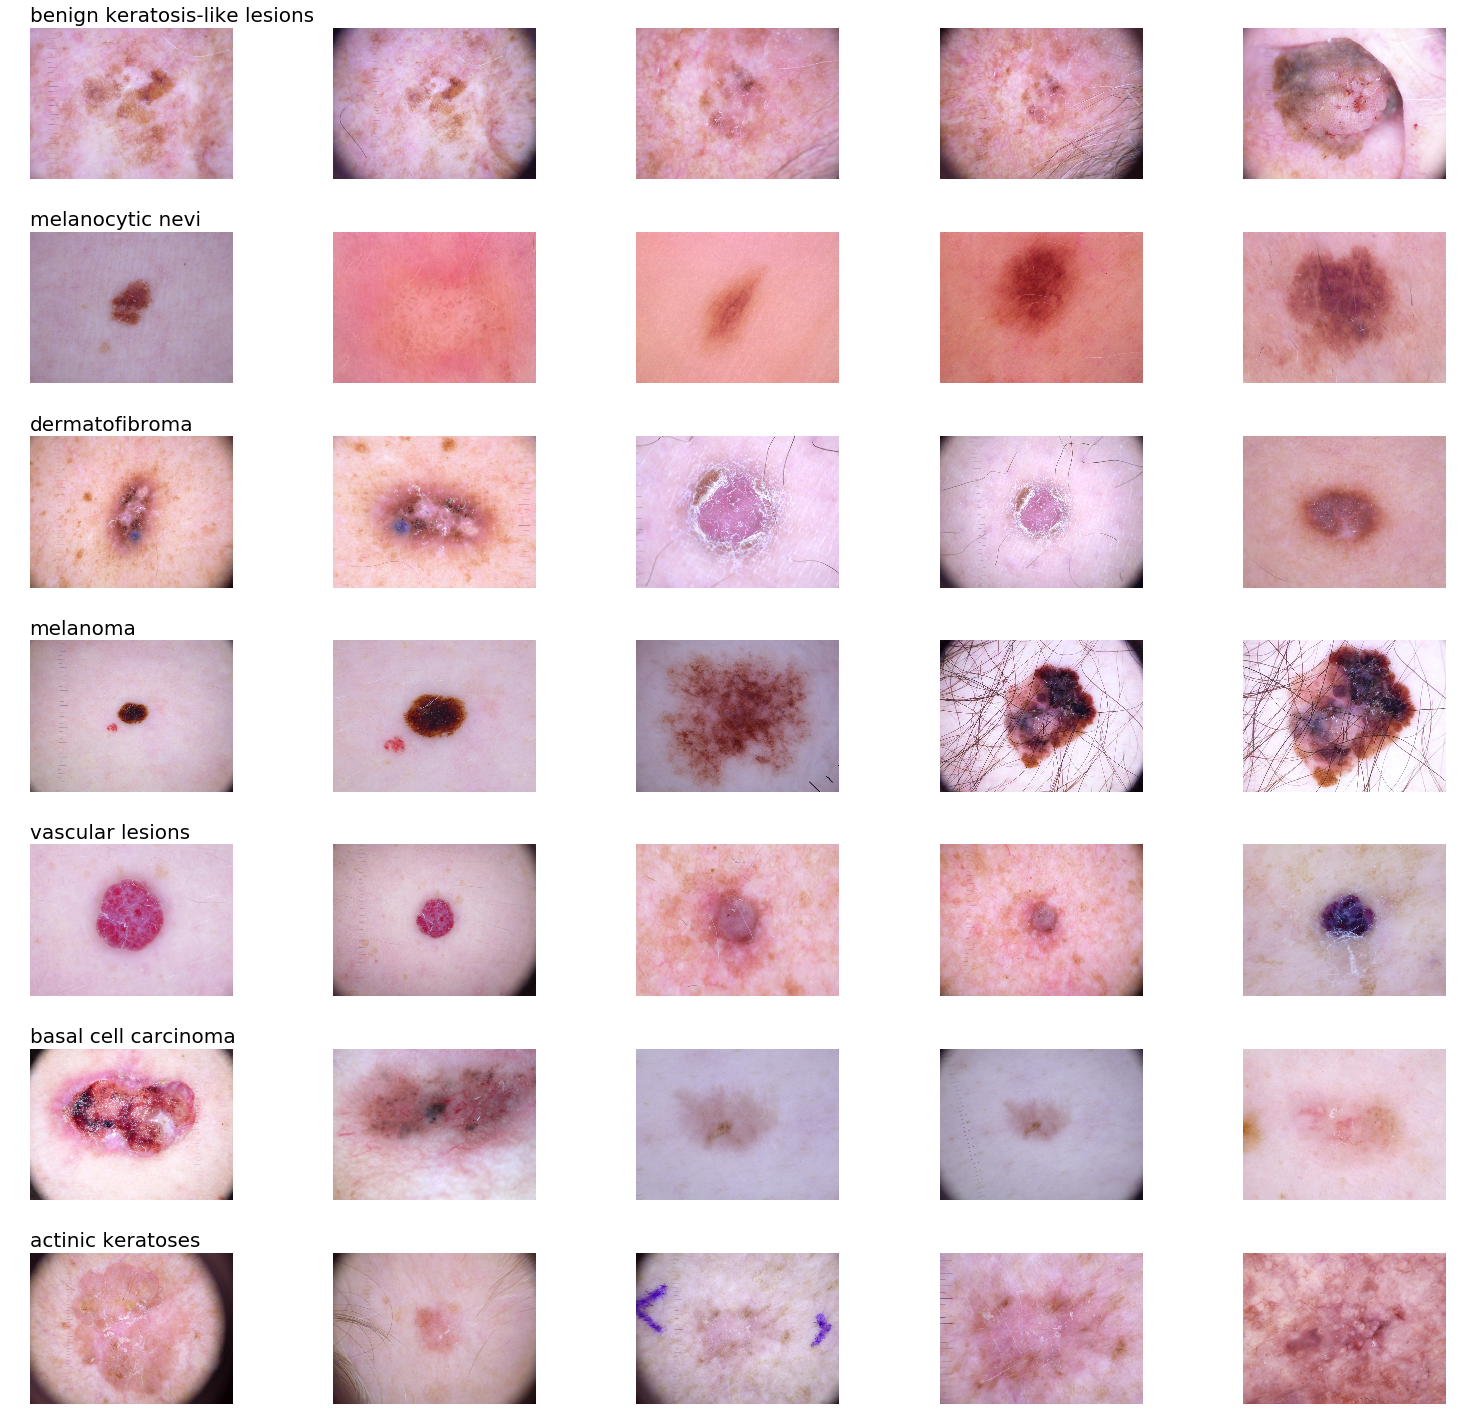

In [11]:
# drawing five samples from each class to see what the images look like in the 450x600 size

label = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
label_images = []
names = ['benign keratosis-like lesions', 'melanocytic nevi', 'dermatofibroma', 'melanoma',
        'vascular lesions','basal cell carcinoma','actinic keratoses']

fig = plt.figure(figsize=(20, 20))
k = range(7)

for i in label:
    
    sample = metadata[metadata['dx'] == i]['image_id'][:5]
    label_images.extend(sample)
    

for position,ID in enumerate(label_images):
        
    im_sample = f'/home/brian/skincancer/images/part1/{ID}.jpg'
    im_sample = imageio.imread(im_sample)

    plt.subplot(7,5,position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(names[title], loc='left', size=20)

plt.tight_layout()
plt.show()

fig.savefig('large_sample.png')

## Image Preprocessing

We will be looking at the 28x28x3 images first to get a sense of what the they look like

In [28]:
image = pd.read_csv('C:/Users/user/Desktop/skincancer/hmnist_28_28_RGB.csv', header=0)
featured_columns = image.columns[:-1]
featured_columns
image = image.drop(image.index[0])

In [29]:
display(image.shape, image.head())

(10014, 2353)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
5,8,1,3,19,5,10,26,8,13,34,...,12,3,7,5,0,1,4,0,0,2


In [30]:
# assigning x and y vairables for modelling

x = image[featured_columns]
y = image.label

In [31]:
x = np.asarray(x)/225
x = x.reshape(-1,28,28,3)
y = np.asarray(y)
print(x.shape, y.shape)

(10014, 28, 28, 3) (10014,)


In [32]:
# train test split

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x, y, test_size=0.4, stratify=y)
print(x_train_s.shape)
print(y_train_s.shape)
print(x_test_s.shape)
print(y_test_s.shape)

(6008, 28, 28, 3)
(6008,)
(4006, 28, 28, 3)
(4006,)


## Architecture

Running a very simple architecture to see get a sense of the baseline accuracy with the smaller pictures

<img src="intro_pic.png">

In [33]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(7))
model.add(Activation(tf.nn.softmax))


#model = Model(inputs, outputs)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
__________

## Training Model

### I.A. size: 28x28x3

In [34]:
y_test_s = to_categorical(y_test_s, num_classes=7)
y_train_s = to_categorical(y_train_s, num_classes=7)

In [35]:
model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['acc'])

history = model.fit(
    x_train_s, y_train_s,
    epochs=150,
    batch_size = 128,
    validation_data=(x_test_s, y_test_s),
    verbose=2)

Train on 6008 samples, validate on 4006 samples
Epoch 1/150
 - 11s - loss: 1.1801 - acc: 0.6585 - val_loss: 1.1136 - val_acc: 0.6695
Epoch 2/150
 - 9s - loss: 1.0252 - acc: 0.6696 - val_loss: 0.9306 - val_acc: 0.6695
Epoch 3/150
 - 9s - loss: 0.9614 - acc: 0.6668 - val_loss: 0.9235 - val_acc: 0.6695
Epoch 4/150
 - 10s - loss: 0.9294 - acc: 0.6718 - val_loss: 0.9747 - val_acc: 0.6900
Epoch 5/150
 - 10s - loss: 0.9000 - acc: 0.6806 - val_loss: 0.9016 - val_acc: 0.6862
Epoch 6/150
 - 10s - loss: 0.8919 - acc: 0.6808 - val_loss: 0.8529 - val_acc: 0.6945
Epoch 7/150
 - 10s - loss: 0.8593 - acc: 0.6899 - val_loss: 0.8438 - val_acc: 0.6825
Epoch 8/150
 - 10s - loss: 0.8574 - acc: 0.6911 - val_loss: 0.8180 - val_acc: 0.7012
Epoch 9/150
 - 10s - loss: 0.8286 - acc: 0.6952 - val_loss: 0.8360 - val_acc: 0.6925
Epoch 10/150
 - 10s - loss: 0.8024 - acc: 0.7012 - val_loss: 0.7984 - val_acc: 0.7072
Epoch 11/150
 - 11s - loss: 0.7979 - acc: 0.7079 - val_loss: 0.7692 - val_acc: 0.7207
Epoch 12/150
 - 1

Epoch 96/150
 - 10s - loss: 0.0902 - acc: 0.9799 - val_loss: 1.4291 - val_acc: 0.7536
Epoch 97/150
 - 10s - loss: 0.0768 - acc: 0.9839 - val_loss: 1.4993 - val_acc: 0.7521
Epoch 98/150
 - 10s - loss: 0.0848 - acc: 0.9814 - val_loss: 1.6361 - val_acc: 0.7491
Epoch 99/150
 - 10s - loss: 0.1345 - acc: 0.9717 - val_loss: 1.6585 - val_acc: 0.7012
Epoch 100/150
 - 10s - loss: 0.0778 - acc: 0.9817 - val_loss: 2.0682 - val_acc: 0.7327
Epoch 101/150
 - 10s - loss: 0.0764 - acc: 0.9835 - val_loss: 1.5511 - val_acc: 0.7489
Epoch 102/150
 - 10s - loss: 0.0736 - acc: 0.9840 - val_loss: 1.5017 - val_acc: 0.7566
Epoch 103/150
 - 10s - loss: 0.0742 - acc: 0.9815 - val_loss: 1.5414 - val_acc: 0.7549
Epoch 104/150
 - 10s - loss: 0.1554 - acc: 0.9745 - val_loss: 1.5781 - val_acc: 0.7561
Epoch 105/150
 - 10s - loss: 0.0963 - acc: 0.9794 - val_loss: 1.5439 - val_acc: 0.7486
Epoch 106/150
 - 10s - loss: 0.0642 - acc: 0.9857 - val_loss: 1.6074 - val_acc: 0.7541
Epoch 107/150
 - 11s - loss: 0.0646 - acc: 0.98

In [36]:
model.save('model_s.h5')

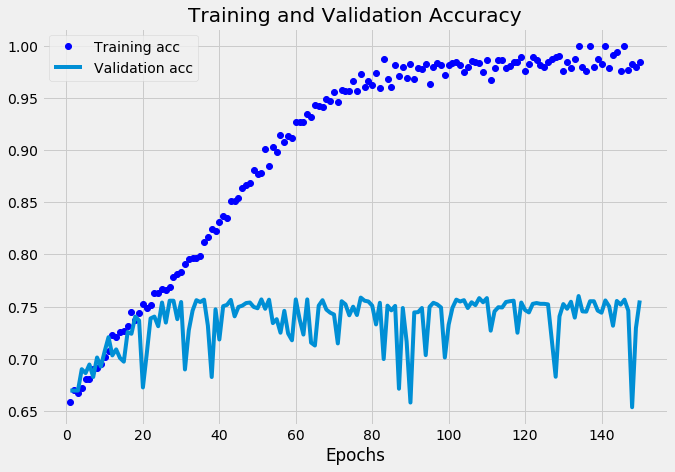

<Figure size 432x288 with 0 Axes>

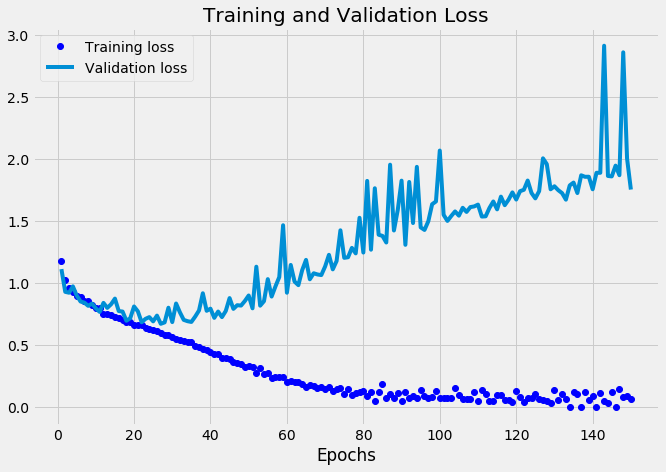

<Figure size 432x288 with 0 Axes>

In [37]:
fig = plt.figure(figsize=(10, 15))

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

In [83]:
y_predict_s = model.predict(x_test_s)

y_predict_classes_s = np.argmax(y_predict_s,axis = 1)
y_true = np.argmax(y_test_s,axis = 1) 
cm_1 = confusion_matrix(y_true,y_predict_classes_s)
cm_1

array([[  41,   28,   26,    2,   20,    0,   14],
       [  14,  103,   31,    8,   36,    3,   11],
       [  29,   15,  224,    3,  114,    4,   50],
       [   5,   11,    4,   11,   11,    0,    4],
       [  14,   10,  101,    7, 2455,    6,   89],
       [   0,    5,    0,    0,   11,   39,    2],
       [  19,   10,   68,    2,  186,    5,  155]], dtype=int64)

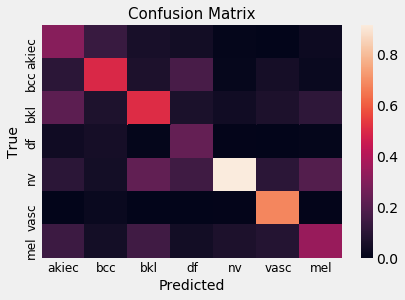

In [84]:
ax= plt.subplot()
sns.heatmap(cm_1 / cm_1.astype(np.float).sum(axis=1), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=14);
ax.set_ylabel('True', size=14); 
ax.set_title('Confusion Matrix', size=15); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'],size=12);

In [75]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: 0.7408681417931589
recall: 0.7558662006989516
fscore: 0.746583978133512


In [82]:
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_predict_classes_s)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.33606557 0.56593407 0.49339207 0.33333333 0.86657254 0.68421053
 0.47692308]
recall: [0.3129771  0.5        0.51025057 0.23913043 0.91536167 0.68421053
 0.34831461]
fscore: [0.32411067 0.53092784 0.50167973 0.27848101 0.89029918 0.68421053
 0.4025974 ]


**High accuracy but very unstable outputs; we see signs of overfitting as well.** <br>
**Significant deterioation after epoch 20, let's try fitting it to only epoch=20 and check accuracy via confusion matrix.** <br>

### I.B. 20 Epochs

In [42]:
model_1a = Sequential()

model_1a.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3)))
model_1a.add(MaxPool2D((2, 2)))
model_1a.add(Conv2D(64, (3, 3), activation='relu'))
model_1a.add(MaxPool2D((2, 2)))
model_1a.add(Conv2D(128, (3, 3), activation='relu'))
model_1a.add(MaxPool2D((2, 2)))

model_1a.add(Flatten())

model_1a.add(Dense(512, activation='relu'))
model_1a.add(Dense(7))
model_1a.add(Activation(tf.nn.softmax))


#model = Model(inputs, outputs)
print(model_1a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
__________

In [43]:
model_1a.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['acc'])

history_1a = model_1a.fit(
    x_train_s, y_train_s,
    epochs=20,
    batch_size = 128,
    validation_data=(x_test_s, y_test_s),
    verbose=2)

Train on 6008 samples, validate on 4006 samples
Epoch 1/20
 - 11s - loss: 1.1450 - acc: 0.6558 - val_loss: 0.9770 - val_acc: 0.6695
Epoch 2/20
 - 10s - loss: 0.9913 - acc: 0.6689 - val_loss: 0.9965 - val_acc: 0.6695
Epoch 3/20
 - 10s - loss: 0.9567 - acc: 0.6738 - val_loss: 0.8878 - val_acc: 0.6697
Epoch 4/20
 - 10s - loss: 0.9164 - acc: 0.6788 - val_loss: 0.9111 - val_acc: 0.6912
Epoch 5/20
 - 10s - loss: 0.9005 - acc: 0.6821 - val_loss: 0.8470 - val_acc: 0.6952
Epoch 6/20
 - 10s - loss: 0.8741 - acc: 0.6901 - val_loss: 0.8907 - val_acc: 0.6970
Epoch 7/20
 - 11s - loss: 0.8501 - acc: 0.6944 - val_loss: 0.9548 - val_acc: 0.6415
Epoch 8/20
 - 10s - loss: 0.8376 - acc: 0.6994 - val_loss: 0.8415 - val_acc: 0.7034
Epoch 9/20
 - 10s - loss: 0.8184 - acc: 0.7017 - val_loss: 0.8036 - val_acc: 0.7000
Epoch 10/20
 - 11s - loss: 0.8020 - acc: 0.7059 - val_loss: 0.7495 - val_acc: 0.7214
Epoch 11/20
 - 10s - loss: 0.7726 - acc: 0.7144 - val_loss: 0.7356 - val_acc: 0.7262
Epoch 12/20
 - 10s - loss:

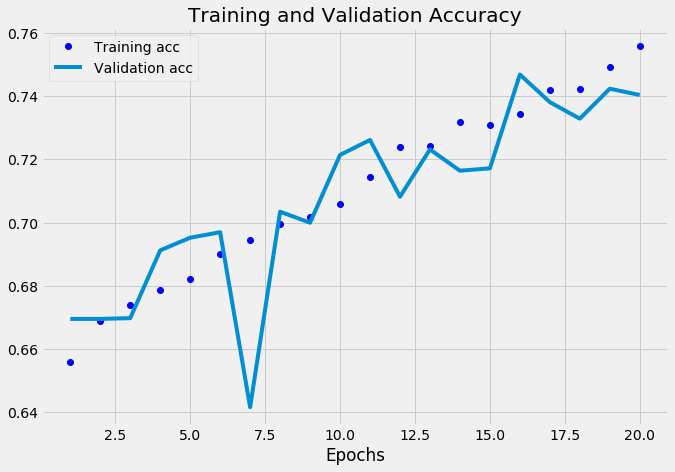

<Figure size 432x288 with 0 Axes>

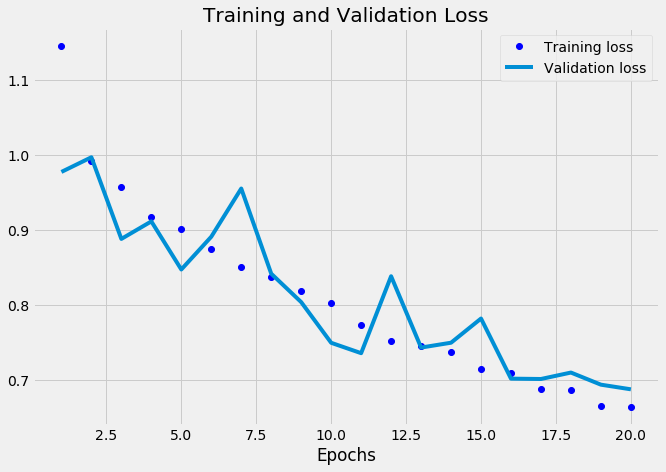

<Figure size 432x288 with 0 Axes>

In [44]:
fig = plt.figure(figsize=(10, 15))

accuracy = history_1a.history['acc']
val_accuracy = history_1a.history['val_acc']
loss = history_1a.history['loss']
val_loss = history_1a.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

In [85]:
y_predict_s = model_1a.predict(x_test_s)

y_predict_classes_s = np.argmax(y_predict_s,axis = 1)
y_true = np.argmax(y_test_s,axis = 1) 
cm_2 = confusion_matrix(y_true,y_predict_classes_s)
cm_2

array([[  23,   13,   57,    0,   24,    0,   14],
       [  22,   59,   63,    0,   52,    2,    8],
       [   7,   11,  243,    0,  165,    2,   11],
       [  10,   10,   14,    0,    9,    0,    3],
       [   3,    8,   97,    0, 2537,    6,   31],
       [   0,    9,    0,    0,   18,   30,    0],
       [   4,    8,   56,    0,  299,    4,   74]], dtype=int64)

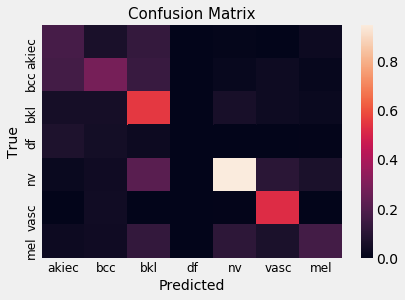

In [86]:
ax= plt.subplot()
sns.heatmap(cm_2 / cm_2.astype(np.float).sum(axis=1), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=14);
ax.set_ylabel('True', size=14); 
ax.set_title('Confusion Matrix', size=15); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12);



In [77]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

C:\Users\user\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.7020567790034793
recall: 0.7403894158761857
fscore: 0.7048301210784454


In [78]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

C:\Users\user\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: [0.33333333 0.5        0.45849057 0.         0.81733247 0.68181818
 0.5248227 ]
recall: [0.17557252 0.28640777 0.55353075 0.         0.94593587 0.52631579
 0.16629213]
fscore: [0.23       0.36419753 0.50154799 0.         0.87694435 0.59405941
 0.25255973]


### II. size: 28x28x3 - Adding Dropout & Hidden layers to tweak the model

In [42]:
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(x, y, test_size=0.5)
print(x_train_st.shape)
print(y_train_st.shape)
print(x_test_st.shape)
print(y_test_st.shape)

(5007, 28, 28, 3)
(5007,)
(5007, 28, 28, 3)
(5007,)


In [43]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,3)))
model_2.add(MaxPool2D((2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPool2D((2, 2)))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPool2D((2, 2)))

model_2.add(Flatten())

model_2.add(Dense(250, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(250, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(7, activation='softmax'))
#model.add(Activation(tf.nn.softmax))


#model = Model(inputs, outputs)
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 2, 128)         147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 1, 1, 128)         0         
__________

In [48]:
model_2.compile('rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(
    x, to_categorical(y),
    epochs=150, batch_size=200,
    validation_split=0.1,
    verbose=1,
    callbacks=[ModelCheckpoint('model_2.h5', save_best_only=True)]
)

Train on 9012 samples, validate on 1002 samples
Epoch 1/150
9012/9012 [==============================] - 14s 2ms/step - loss: 0.8572 - acc: 0.6771 - val_loss: 5.1630 - val_acc: 0.4820
Epoch 2/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.7584 - acc: 0.7092 - val_loss: 3.6015 - val_acc: 0.5749
Epoch 3/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.7320 - acc: 0.7184 - val_loss: 4.7918 - val_acc: 0.6517
Epoch 4/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.7119 - acc: 0.7301 - val_loss: 5.4423 - val_acc: 0.5549
Epoch 5/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.7007 - acc: 0.7360 - val_loss: 4.6800 - val_acc: 0.5788
Epoch 6/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.6847 - acc: 0.7398 - val_loss: 4.7165 - val_acc: 0.6447
Epoch 7/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.6701 - acc: 0.7468 - val_loss: 5.1583 - val_acc: 0.6667


Epoch 120/150
9012/9012 [==============================] - 15s 2ms/step - loss: 0.0601 - acc: 0.9846 - val_loss: 6.6649 - val_acc: 0.4401
Epoch 121/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.0565 - acc: 0.9840 - val_loss: 7.0021 - val_acc: 0.4721
Epoch 122/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.0868 - acc: 0.9775 - val_loss: 6.4730 - val_acc: 0.4860
Epoch 123/150
9012/9012 [==============================] - 14s 2ms/step - loss: 0.0628 - acc: 0.9809 - val_loss: 6.6815 - val_acc: 0.4810
Epoch 124/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.0753 - acc: 0.9814 - val_loss: 6.7432 - val_acc: 0.4840
Epoch 125/150
9012/9012 [==============================] - 13s 1ms/step - loss: 0.0690 - acc: 0.9846 - val_loss: 6.7234 - val_acc: 0.4950
Epoch 126/150
9012/9012 [==============================] - 14s 2ms/step - loss: 0.0898 - acc: 0.9770 - val_loss: 6.7651 - val_acc: 0.4711
Epoch 127/150
9012/9012 [=========

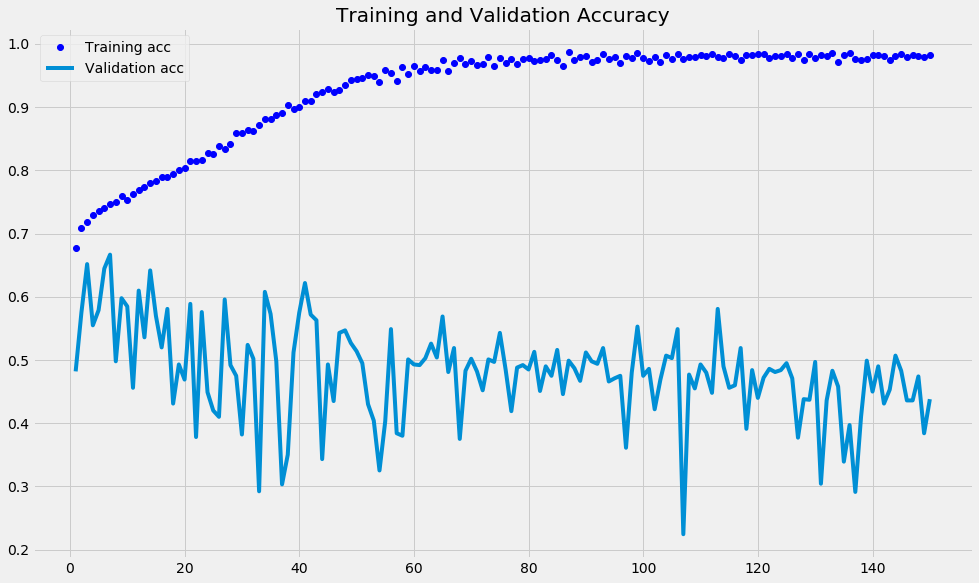

<Figure size 432x288 with 0 Axes>

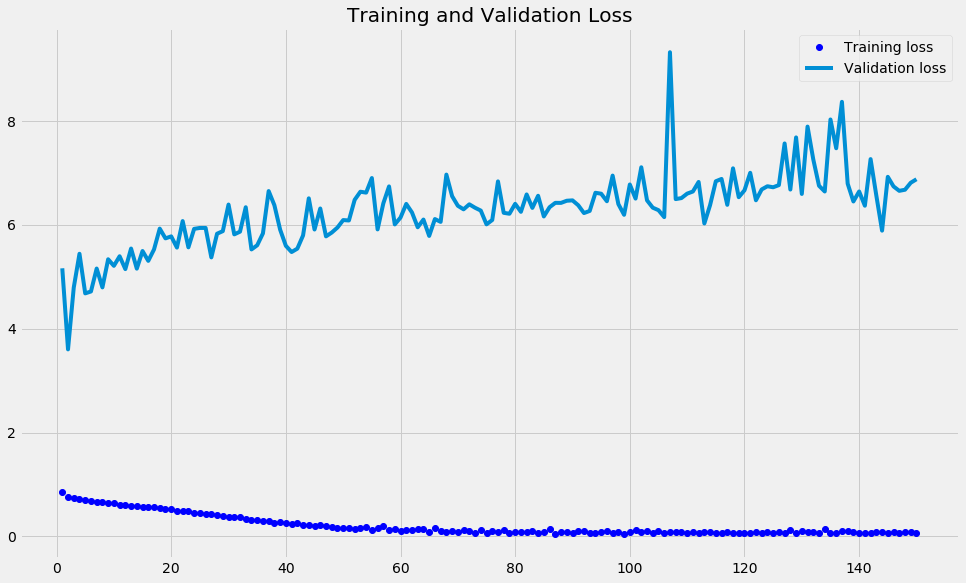

<Figure size 432x288 with 0 Axes>

In [50]:
fig = plt.figure(figsize=(15, 20))

accuracy = history_2.history['acc']
val_accuracy = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(15, 20))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

__*Accuracy dropped compared to the baseline model and loss increased by more than the double.*__<br>
__*Does well on the training data, but not good on the validation data.*__<br>
__*Keep in mind we did not account for class imbalance.*__<br>
__*Would images of higher resolution resolve this problem?*__

### III. size: 450x600x3 - Balancing Class

In [4]:
metadata_image = metadata
metadata_image.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


In [5]:
# there is a class imbalance, 6,705 instances in melanocytic nevi

metadata_image.label.value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64

In [8]:
# Assigning X and y values to feed into our model

X = metadata_image
y = metadata_image['label']


# resolving the issue of class imabalance using the random under sampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)


# size of our X and y vairables after adjusting for class imbalance; checking what each instance of X_resampled looks like

print(X_resampled.shape)
print(y_resampled.shape)

print(X_resampled[0, :])

(805, 8)
(805,)
['HAM_0002734' 'ISIC_0028190' 'akiec' 'histo' 45.0 'male' 'face' 0]


In [9]:
# checking the number of images in each class, our classes are now balanced

np.unique(y_resampled, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([115, 115, 115, 115, 115, 115, 115]))

__Assigning x and y values for model training__

In [10]:
# Assinging X, and y 

image_ids = X_resampled[:,1]
y = y_resampled

In [11]:
# loading 805 images

image_array = []
num_images = 805
i=0

for ID in tqdm(image_ids):
    im = f'/home/brian/skincancer/images/part1/{ID}.jpg'
    im = np.asarray(imageio.imread(im))
    image_array.append(im)

    i +=1
    if i == num_images:
        break

 99%|█████████▉| 800/805 [00:08<00:00, 94.14it/s] 


In [12]:
# reducing total intensity of each pixel to range 0 to 1 to reduce computation time

x_images = np.asarray(image_array) / 255
print(x_images.shape)
print(y.shape)

(805, 450, 600, 3)
(805,)


In [28]:
# Building the same baseline architecture we used earlier with the 28x28 images

cnn = Sequential()

cnn.add(MaxPool2D((4, 4), input_shape=(450, 600,3)))

cnn.add(Conv2D(32, (3, 3), strides = (3,3), padding ='same', activation='relu'))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
cnn.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Dropout(0.40))
cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(7, activation='softmax'))

print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_8 (MaxPooling2 (None, 112, 150, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 38, 50, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 38, 50, 32)        9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 38, 50, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 38, 50, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 38, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 25, 64)        0         
__________

In [29]:
# Complied Model

cnn.compile('rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = cnn.fit(
    x_images, to_categorical(y),
    epochs=150, batch_size=200,
    validation_split=0.1,
    verbose=1,
    callbacks=[ModelCheckpoint('skin-cancer.h5', save_best_only=True)]
)

Train on 724 samples, validate on 81 samples
Epoch 1/150
724/724 [==============================] - 15s 21ms/step - loss: 3.4694 - acc: 0.1450 - val_loss: 2.0495 - val_acc: 0.0000e+00
Epoch 2/150
724/724 [==============================] - 13s 18ms/step - loss: 1.9284 - acc: 0.1381 - val_loss: 2.2129 - val_acc: 0.0000e+00
Epoch 3/150
724/724 [==============================] - 14s 19ms/step - loss: 1.9200 - acc: 0.1713 - val_loss: 2.6214 - val_acc: 0.0000e+00
Epoch 4/150
724/724 [==============================] - 13s 18ms/step - loss: 2.1635 - acc: 0.1588 - val_loss: 2.8488 - val_acc: 0.0000e+00
Epoch 5/150
724/724 [==============================] - 14s 19ms/step - loss: 1.9008 - acc: 0.1630 - val_loss: 2.4533 - val_acc: 0.0000e+00
Epoch 6/150
724/724 [==============================] - 13s 18ms/step - loss: 1.8928 - acc: 0.2003 - val_loss: 2.7352 - val_acc: 0.0000e+00
Epoch 7/150
724/724 [==============================] - 14s 19ms/step - loss: 1.8887 - acc: 0.1796 - val_loss: 3.1082 - va

724/724 [==============================] - 15s 21ms/step - loss: 0.0501 - acc: 0.9862 - val_loss: 3.5091 - val_acc: 0.5679
Epoch 121/150
724/724 [==============================] - 14s 20ms/step - loss: 0.0415 - acc: 0.9917 - val_loss: 4.1329 - val_acc: 0.5556
Epoch 122/150
724/724 [==============================] - 14s 19ms/step - loss: 0.0593 - acc: 0.9793 - val_loss: 4.1914 - val_acc: 0.5679
Epoch 123/150
724/724 [==============================] - 13s 18ms/step - loss: 0.8979 - acc: 0.7693 - val_loss: 5.7510 - val_acc: 0.2593
Epoch 124/150
724/724 [==============================] - 14s 19ms/step - loss: 0.2866 - acc: 0.9006 - val_loss: 2.9947 - val_acc: 0.5926
Epoch 125/150
724/724 [==============================] - 14s 19ms/step - loss: 0.1108 - acc: 0.9627 - val_loss: 4.0544 - val_acc: 0.4938
Epoch 126/150
724/724 [==============================] - 14s 19ms/step - loss: 0.0667 - acc: 0.9848 - val_loss: 3.6472 - val_acc: 0.5679
Epoch 127/150
724/724 [==============================] 

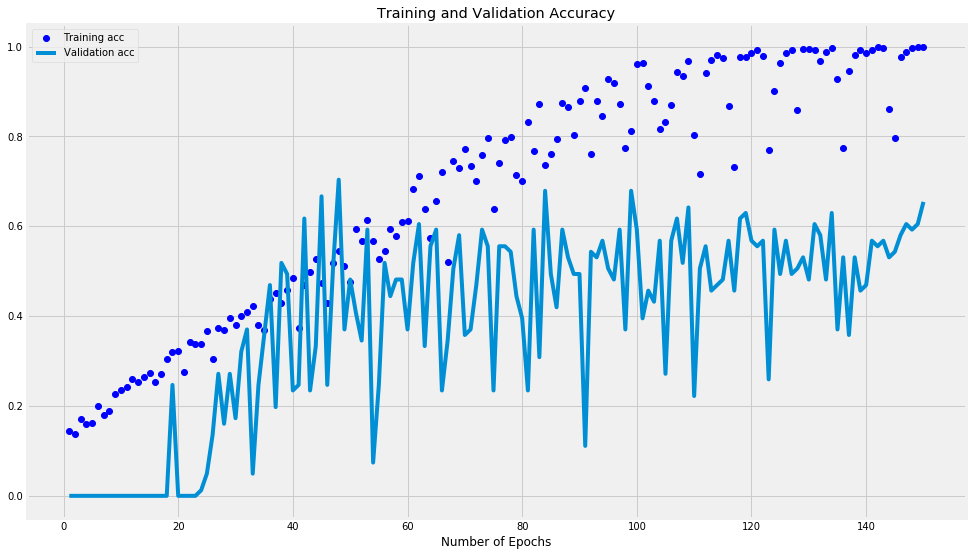

<Figure size 432x288 with 0 Axes>

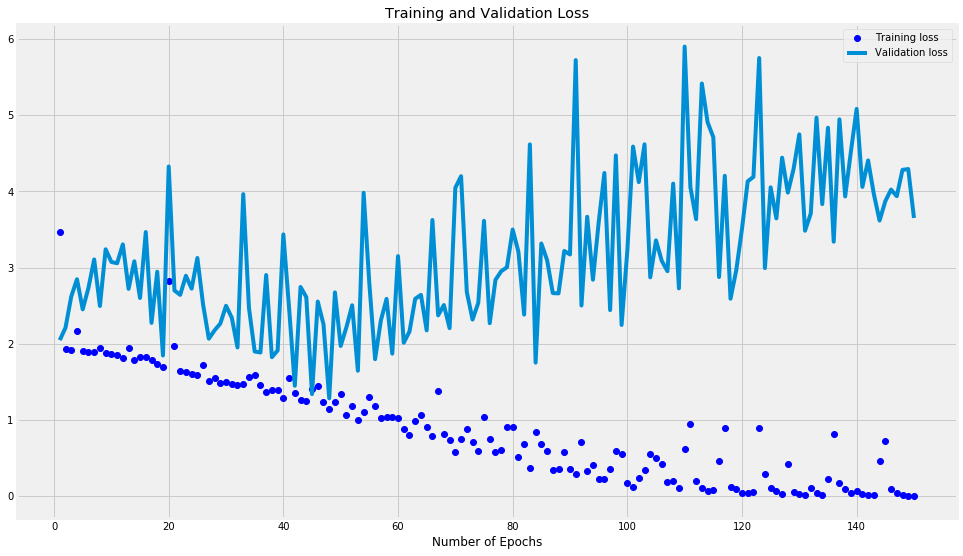

<Figure size 432x288 with 0 Axes>

In [30]:
fig = plt.figure(figsize=(15, 20))

accuracy = history_3.history['acc']
val_accuracy = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(15, 20))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

#### *more unstable than what we saw for the low resolution images*
#### *loss fuction is still increasing*
#### *overfitting on training data*

# Further Optimization

### IV. size: 450x600x3 - Standard Scaling + Image Augmentation

In [13]:
# standard scaling the pixels to reduce computation time

x_train_standard, x_test_standard, y_train_standard, y_test_standard = train_test_split(x_images, y, test_size=.3)
print(x_train_standard.shape)
print(x_test_standard.shape)
print(y_train_standard.shape)
print(y_test_standard.shape)

(563, 450, 600, 3)
(242, 450, 600, 3)
(563,)
(242,)


In [14]:
x_train_mean = np.mean(x_train_standard)
x_train_std = np.std(x_train_standard)
x_test_mean = np.mean(x_test_standard)
x_test_std = np.std(x_test_standard)

x_train_standard = (x_train_standard - x_train_mean) / x_train_std
x_test_standard = (x_test_standard - x_test_mean) / x_test_std

In [15]:
y_test_standard = to_categorical(y_test_standard, num_classes=7)
y_train_standard = to_categorical(y_train_standard, num_classes=7)

In [16]:
# image augmentation to reduce overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_standard)

In [17]:
# building an architecture with dropout layers to further reduce overfitting and increase stability of model

model_4 = Sequential()

model_4.add(MaxPool2D((4, 4), input_shape=(450, 600,3)))

model_4.add(Conv2D(32, (3, 3), padding ='same', activation='relu'))
model_4.add(Conv2D(32, (3, 3),  padding='same', activation='relu'))
model_4.add(MaxPool2D((2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
model_4.add(Conv2D(64, (3, 3), activation='relu',padding ='same'))
model_4.add(MaxPool2D((2, 2)))
model_4.add(Dropout(0.40))
model_4.add(Flatten())

model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(7, activation='softmax'))

print(model_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 112, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 75, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 75, 64)        36928     
__________

In [18]:
optimizer = Adam(lr=0.001, beta_1=.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [19]:
# Complied Model

model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history_4 = model_4.fit_generator(
    datagen.flow(x_train_standard, y_train_standard,batch_size=10),
    epochs=50,
    validation_data=(x_test_standard, y_test_standard),
    verbose=1,
    steps_per_epoch=x_train_standard.shape[0],
    callbacks=[ModelCheckpoint('skin-cancer-4.h5', save_best_only=True)]
)

Epoch 1/50
563/563 [==============================] - 782s 1s/step - loss: 1.8491 - acc: 0.2565 - val_loss: 1.7617 - val_acc: 0.2934
Epoch 2/50
563/563 [==============================] - 779s 1s/step - loss: 1.5894 - acc: 0.3728 - val_loss: 1.6715 - val_acc: 0.3512
Epoch 3/50
563/563 [==============================] - 778s 1s/step - loss: 1.4768 - acc: 0.4382 - val_loss: 1.6708 - val_acc: 0.3802
Epoch 4/50
563/563 [==============================] - 779s 1s/step - loss: 1.3505 - acc: 0.4837 - val_loss: 1.7241 - val_acc: 0.3843
Epoch 5/50
563/563 [==============================] - 774s 1s/step - loss: 1.2170 - acc: 0.5258 - val_loss: 1.8196 - val_acc: 0.3636
Epoch 6/50
563/563 [==============================] - 779s 1s/step - loss: 1.0460 - acc: 0.6028 - val_loss: 1.7570 - val_acc: 0.3926
Epoch 7/50
563/563 [==============================] - 779s 1s/step - loss: 0.8888 - acc: 0.6615 - val_loss: 1.9033 - val_acc: 0.4504
Epoch 8/50
563/563 [==============================] - 782s 1s/step - 

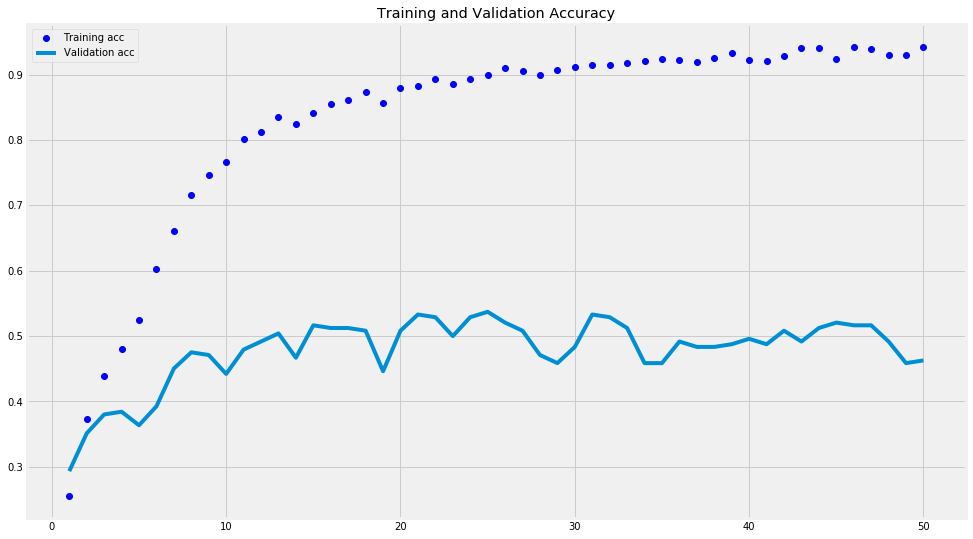

<Figure size 432x288 with 0 Axes>

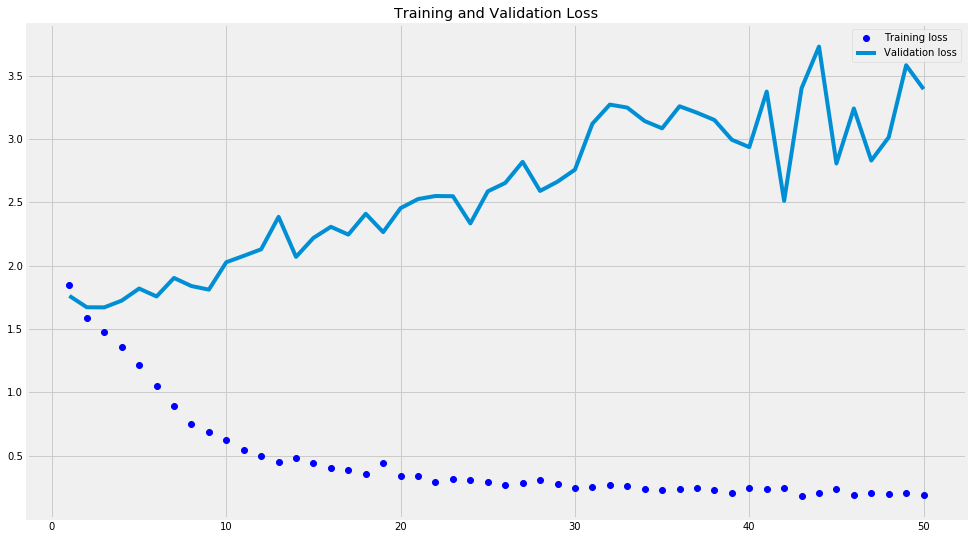

<Figure size 432x288 with 0 Axes>

In [23]:
fig = plt.figure(figsize=(15, 20))

accuracy = history_4.history['acc']
val_accuracy = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(15, 20))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

## Conclusion

__Findings:__ accuracy is higher if model is trained on more samples of lower resolution than small samples of high resolutions.

__Improvements__: 
- loss is still increasing in every model (optimizer is not steering the model towards the right direction)
- low resolution 
    - accuracy is the highest but unstable
    - loss: between 1 to 2.5
    - adding dropout layers did not help with reducing overfitting, but in turn reduced accuracy scores
    - overfit on training data 
    - everything was done on unscaled, imbalanced class
- high resolution
    - accuracy score is lower than the low resolution model 
    - more unstable and noiser than the low resolution model 
    - loss is between 2 to 6, much higher than low resolution 
    - only had 800 pictuers left in total after fixing class imbalance issue
    
Going forward, can continue to refine the model to achieve a stable decrease in loss function with every epoch, build an interface such that given an image of a skin lesion within the two classes, the output will give a % probability of which of the seven classes it belongs to. 